## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.
--2022-05-13 01:25:41--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  31.5MB/s    in 0.4s    

2022-05-13 01:25:43 (31.5 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [2]:
path_do_data = './data.txt'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.legacy.datasets import TranslationDataset
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [4]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [5]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.legacy.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [6]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [8]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [9]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9225
Unique tokens in target (en) vocabulary: 6704


Here are tokens from original (RU) corpus:

In [10]:
SRC.vocab.itos[::1000]

['<unk>',
 'горячий',
 'спутникового',
 'интернациональные',
 'antica',
 'azul',
 'motel',
 'уютное',
 'душа',
 'тривандрум']

And from target (EN) corpus:

In [11]:
TRG.vocab.itos[::1000]

['<unk>', 'ngurah', 'isola', 'eiffel', 'marsala', 'soyembika', 'map']

And here is example from train dataset:

In [12]:
print(vars(train_data.examples[9]))

{'trg': ['grocery', 'store', 'is', '1', '-', 'minute', 'walk', 'from', 'the', 'apartment', '.'], 'src': ['продуктовый', 'магазин', 'находится', 'в', '1', 'минуте', 'ходьбы', 'от', 'апартаментов', '.']}


Let's check the length distributions:

Length distribution in Train data


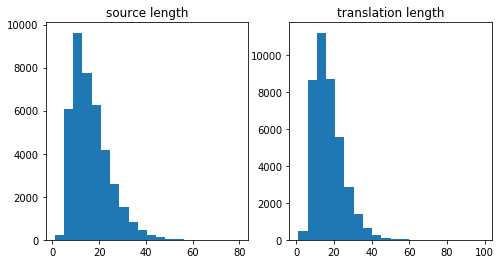

In [13]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


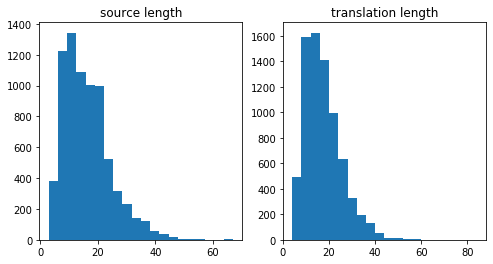

In [14]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda')

In [17]:
def _len_sort_key(x):
    return len(x.src)

# BATCH_SIZE = 128
BATCH_SIZE = 64  # изменено, тк были проблемы с памятью на gpu

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [18]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 64]
	[.trg]:[torch.cuda.LongTensor of size 66x64 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 68x64 (GPU 0)]
torch.Size([68, 64]) torch.Size([66, 64])


In [19]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [21]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9225, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6704, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6704, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,873,392 trainable parameters


In [23]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [24]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, use_plot=True):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if use_plot and (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

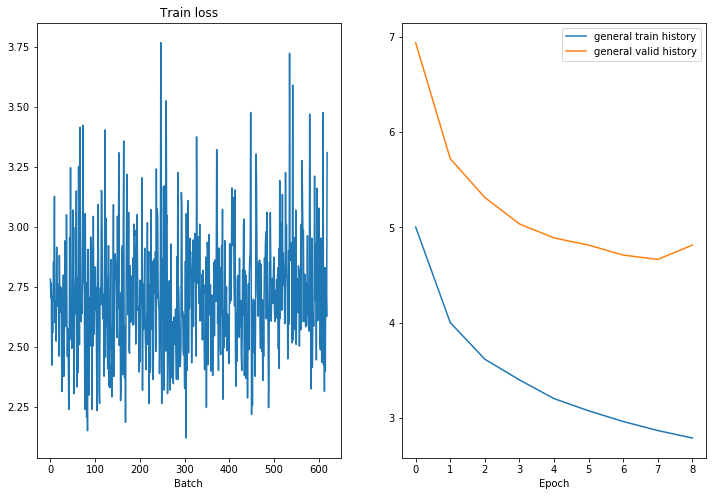

Epoch: 10 | Time: 1m 19s
	Train Loss: 2.714 | Train PPL:  15.096
	 Val. Loss: 4.604 |  Val. PPL:  99.864


In [28]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [29]:
del utils

NameError: name 'utils' is not defined

In [30]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [31]:
batch = next(iter(test_iterator))

In [32]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: you will find a 24 - hour front desk at the property .
Generated: there is a 24 - hour front desk and a tour desk .

Original: bed linen is available .
Generated: en suite bathroom .



In [33]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [34]:
import tqdm

In [35]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

118it [00:02, 43.54it/s]


In [36]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

16.049145938601328

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points

## Эксперименты

Во многом источником послужил замечательный туториал https://github.com/bentrevett/pytorch-seq2seq

Вначале зафиксируем random seed для воспроизводимости.

In [4]:
import numpy as np

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Экспримент 1

Возьмем за основу наш бейзлайн и сделаем следующие изменения:
1. В качестве токенайзера будем использовать вместо WordPunctTokenizer токентайзер из spacy для русского и английского языка, чтобы правильнее разбивать текст на токены с учетом специфики языка.
2. Вместо LSTM будем использовать GRU
3. Самое главное: в декодере будем использовать attention. Это должно позволить улучшить качетсво перевода, т.к. при генерации каждого следующего токена мы будем учитывать, какая информация из входной последовательности на данном шаге наиболее важна.

In [24]:
from rnn_and_attention.runner import prepare_data, create_model, train_model, predict_model
from split_data import get_iterators
from metrics import calc_metrics

%load_ext autoreload
%autoreload 2

In [7]:
train_data, valid_data, test_data, src_field, trg_field = prepare_data()

In [8]:
train_iterator, valid_iterator, test_iterator = get_iterators(train_data, valid_data, test_data,
                                                              device='cuda', batch_size=64)

In [9]:
rnn_attn_model = create_model(len(src_field.vocab), len(trg_field.vocab))

In [10]:
rnn_attn_model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9324, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6803, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6803, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Epoch: 01 | Time: 1m 54s
	Train Loss: 3.967 | Train PPL:  52.823
	 Val. Loss: 4.584 |  Val. PPL:  97.902
Epoch: 02 | Time: 1m 55s
	Train Loss: 2.970 | Train PPL:  19.484
	 Val. Loss: 4.272 |  Val. PPL:  71.669
Epoch: 03 | Time: 1m 56s
	Train Loss: 2.591 | Train PPL:  13.342
	 Val. Loss: 4.114 |  Val. PPL:  61.214
Epoch: 04 | Time: 1m 56s
	Train Loss: 2.322 | Train PPL:  10.193
	 Val. Loss: 4.204 |  Val. PPL:  66.921
Epoch: 05 | Time: 1m 55s
	Train Loss: 2.131 | Train PPL:   8.426
	 Val. Loss: 4.173 |  Val. PPL:  64.936
Epoch: 06 | Time: 1m 55s
	Train Loss: 1.985 | Train PPL:   7.278
	 Val. Loss: 4.170 |  Val. PPL:  64.739
Epoch: 07 | Time: 1m 56s
	Train Loss: 1.852 | Train PPL:   6.375
	 Val. Loss: 4.310 |  Val. PPL:  74.407
Epoch: 08 | Time: 1m 55s
	Train Loss: 1.759 | Train PPL:   5.809
	 Val. Loss: 4.349 |  Val. PPL:  77.402
Epoch: 09 | Time: 1m 56s
	Train Loss: 1.678 | Train PPL:   5.357
	 Val. Loss: 4.356 |  Val. PPL:  77.908
Epoch: 10 | Time: 1m 55s
	Train Loss: 1.604 | Train PPL

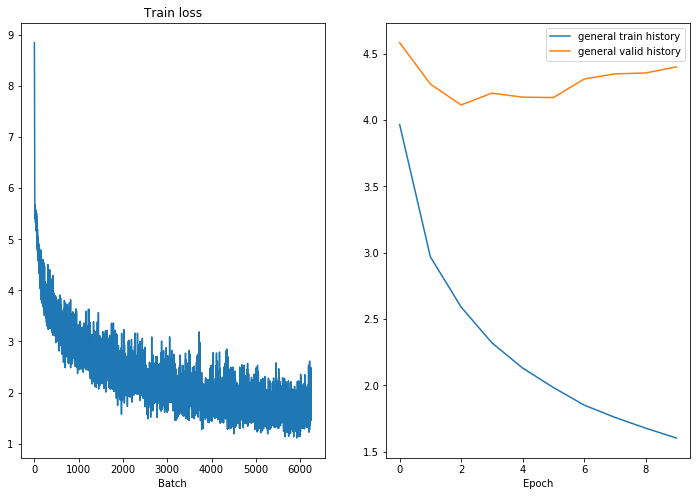

In [12]:
train_model(rnn_attn_model, train_iterator, valid_iterator, trg_field, n_epochs=10)

In [17]:
calc_metrics(rnn_attn_model, predict_model, trg_field, test_iterator)

118it [00:04, 28.23it/s]


elapsed: 4.181312799453735
time for batch with size 32 = 0.017717427116329388 s
bleu: 28.203460942319143

best 3 translations:

	original: there is a 24 - hour front desk at the property .
	generated: there is a 24 - hour front desk at the property .
	score = 100.0

	original: the property offers free parking .
	generated: the property offers free parking .
	score = 100.0

	original: you will find a kettle in the room .
	generated: you will find a kettle in the room .
	score = 100.0

worst 3 translations:

	original: home to one of the first art museums in israel , country also houses the archaeological centre .
	generated: .
	score = 7.542270970394191e-237

	original: the
	generated: guest house offers accommodation in .
	score = 0

	original: bikes can be rented on site .
	generated: bike hire is available at the property and the property is available for rent
	score = 0



И действительно, введение attention позволило сходу сильно увеличить качество перевода и побить порог в 25 по BLEU.

Интересно, что уже после 3-й эпохи наступает переобучение.

### Эксперимент 2

Теперь проверим следующую идею. В бейзлайне мы обучали эмбеддинги с нуля. Кажется, что если сразу инициализировать эмбеддинги в энкодере хорошими значениями, то можно улучшить качество перевода. В качестве эмбеддингов возьмем rubert от deeppavlov. Также при этом изменим инициализацию весов модели: раньше мы для всех весов брали просто семплы из равномерного распределения, теперь же эмбеддинги мы уже инициализировали, так что их будем пропускать. Также было испробовано 2 варианта:
- замораживать слой эмбеддингов
- дообучать этот слой

Первый вариант показал плохие результаты, что и логично: мы не позволяем модели подстроится под нашу задачу.

In [54]:
from pretrained_embeddings.runner import prepare_data, create_model, train_model, predict_model, get_original_text, get_generated_text

In [55]:
train_data, valid_data, test_data, src_field, trg_field = prepare_data()

In [56]:
train_iterator, valid_iterator, test_iterator = get_iterators(train_data, valid_data, test_data,
                                                              device='cuda', batch_size=64)

In [57]:
pretrained_model = create_model(len(src_field.vocab), len(trg_field.vocab), src_field)

Some weights of the model checkpoint at /home/a.gorlenko/nlp/lab2/rubert_cased_L-12_H-768_A-12_pt were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
pretrained_model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9376, 768)
    (rnn): LSTM(768, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6792, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6792, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [59]:
print(f'The model has {count_parameters(pretrained_model):,} trainable parameters')

The model has 20,828,808 trainable parameters


Epoch: 01 | Time: 0m 57s
	Train Loss: 4.957 | Train PPL: 142.208
	 Val. Loss: 5.105 |  Val. PPL: 164.805
Epoch: 02 | Time: 0m 57s
	Train Loss: 3.906 | Train PPL:  49.711
	 Val. Loss: 4.945 |  Val. PPL: 140.519
Epoch: 03 | Time: 0m 59s
	Train Loss: 3.507 | Train PPL:  33.332
	 Val. Loss: 4.786 |  Val. PPL: 119.810
Epoch: 04 | Time: 0m 58s
	Train Loss: 3.277 | Train PPL:  26.496
	 Val. Loss: 4.625 |  Val. PPL: 101.998
Epoch: 05 | Time: 0m 58s
	Train Loss: 3.095 | Train PPL:  22.086
	 Val. Loss: 4.603 |  Val. PPL:  99.786
Epoch: 06 | Time: 0m 57s
	Train Loss: 2.931 | Train PPL:  18.751
	 Val. Loss: 4.574 |  Val. PPL:  96.930
Epoch: 07 | Time: 0m 57s
	Train Loss: 2.825 | Train PPL:  16.855
	 Val. Loss: 4.495 |  Val. PPL:  89.524
Epoch: 08 | Time: 0m 57s
	Train Loss: 2.727 | Train PPL:  15.291
	 Val. Loss: 4.413 |  Val. PPL:  82.477
Epoch: 09 | Time: 0m 57s
	Train Loss: 2.623 | Train PPL:  13.783
	 Val. Loss: 4.496 |  Val. PPL:  89.686
Epoch: 10 | Time: 0m 57s
	Train Loss: 2.555 | Train PPL

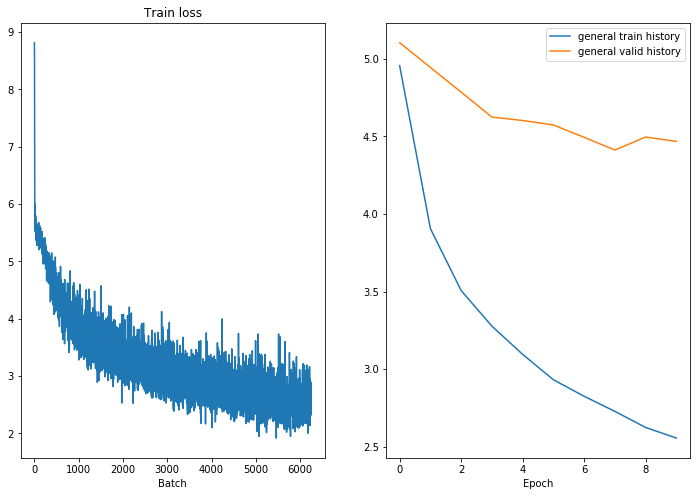

| Test Loss: 4.427 | Test PPL:  83.697 |


In [60]:
train_model(pretrained_model, train_iterator, valid_iterator, test_iterator, trg_field, n_epochs=10)

In [61]:
examples = calc_metrics(pretrained_model, predict_model, get_original_text, get_generated_text, trg_field, test_iterator, 10)

118it [00:02, 50.63it/s]


elapsed: 2.3318159580230713
time for batch with size 32 = 0.009880576093318098 s
bleu: 18.125087813742898

best 10 translations:

	original: the bathroom comes with a shower .
	generated: the bathroom comes with a shower .
	score = 100.0

	original: towels are provided .
	generated: towels are provided .
	score = 100.0

	original: free wifi access is available .
	generated: free wifi access is available .
	score = 100.0

	original: rooms include a tv .
	generated: rooms include a tv .
	score = 100.0

	original: some have a balcony .
	generated: some have a balcony .
	score = 100.0

	original: guests can enjoy the on - site restaurant .
	generated: guests can enjoy the on - site restaurant .
	score = 100.0

	original: free private parking is available .
	generated: free private parking is available .
	score = 100.0

	original: private parking is available on site .
	generated: private parking is available on site .
	score = 100.0

	original: the property also offers grocery delivery .
	

Видим, что действительно удалось добиться улучшения качества, но, однако, не очень большого. В нашей шкале удалось только преодолеть самый первый порог 18. Изначально я ожидал большего. Видимо, это можно объяснить тем, что только лишь улучшение качества эмбеддингов не способно сильно улучшить изначально наивную модель.

Также видим, что приблизительно с 7 эпохи пошло переобучение.

### Эксперимент 3

В эксперименте 1 мы увидели, что attention в декодере позволяет сильно улучшить качество. Поэтому в данном эксперименте хочется развить эту идею. Причем даже отказавшись от рекуррентной сети. В данном эксперименте в энкодере будем использовать свертки для учета локального контекста и также будем учитывать позиции токенов с помощью эмбеддиногов позиций. В декодере также будем учитывать позиции токенов и локальный контекст с помощью сверток + как и ранее глобальный контекст с помощью attention.

In [111]:
from cnn.runner import prepare_data, create_model, train_model, predict_model, get_original_text, get_generated_text

In [32]:
train_data, valid_data, test_data, src_field, trg_field = prepare_data()

In [33]:
train_iterator, valid_iterator, test_iterator = get_iterators(train_data, valid_data, test_data,
                                                              device='cuda', batch_size=64)

In [34]:
cnn_model = create_model(len(src_field.vocab), len(trg_field.vocab), trg_field)

In [35]:
cnn_model

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9326, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

Epoch: 01 | Time: 0m 53s
	Train Loss: 3.881 | Train PPL:  48.495
	 Val. Loss: 2.674 |  Val. PPL:  14.495
Epoch: 02 | Time: 0m 54s
	Train Loss: 2.653 | Train PPL:  14.197
	 Val. Loss: 2.165 |  Val. PPL:   8.716
Epoch: 03 | Time: 0m 55s
	Train Loss: 2.212 | Train PPL:   9.138
	 Val. Loss: 1.905 |  Val. PPL:   6.719
Epoch: 04 | Time: 0m 55s
	Train Loss: 1.940 | Train PPL:   6.962
	 Val. Loss: 1.817 |  Val. PPL:   6.156
Epoch: 05 | Time: 0m 55s
	Train Loss: 1.755 | Train PPL:   5.781
	 Val. Loss: 1.679 |  Val. PPL:   5.362
Epoch: 06 | Time: 0m 55s
	Train Loss: 1.618 | Train PPL:   5.044
	 Val. Loss: 1.652 |  Val. PPL:   5.216
Epoch: 07 | Time: 0m 55s
	Train Loss: 1.518 | Train PPL:   4.562
	 Val. Loss: 1.630 |  Val. PPL:   5.102
Epoch: 08 | Time: 0m 55s
	Train Loss: 1.436 | Train PPL:   4.204
	 Val. Loss: 1.630 |  Val. PPL:   5.105
Epoch: 09 | Time: 0m 55s
	Train Loss: 1.375 | Train PPL:   3.954
	 Val. Loss: 1.635 |  Val. PPL:   5.131
Epoch: 10 | Time: 0m 55s
	Train Loss: 1.319 | Train PPL

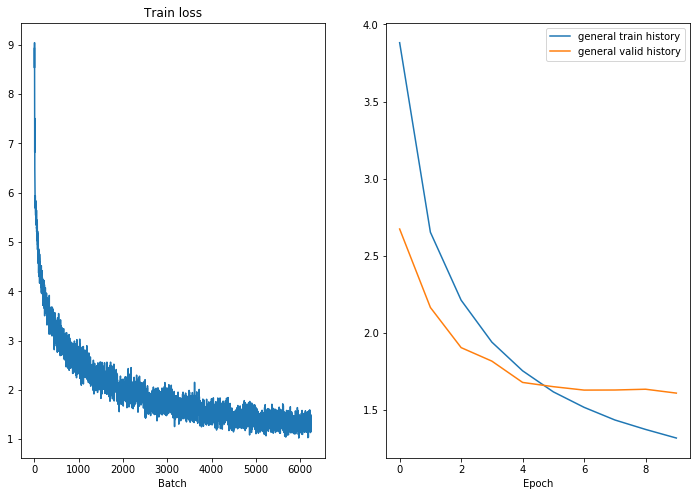

| Test Loss: 1.536 | Test PPL:   4.646 |


In [37]:
train_model(cnn_model, train_iterator, valid_iterator, test_iterator, trg_field, n_epochs=10)

In [133]:
examples = calc_metrics(cnn_model, predict_model, get_original_text, get_generated_text, trg_field, test_iterator, 10)

118it [00:02, 49.42it/s]


elapsed: 2.3891048431396484
time for batch with size 32 = 0.010123325606523934 s
bleu: 37.352602792279185

best 10 translations:

	original: bathrobes are provided .
	generated: bathrobes are provided .
	score = 100.0

	original: bed linen is featured .
	generated: bed linen is featured .
	score = 100.0

	original: towels are featured .
	generated: towels are featured .
	score = 100.0

	original: the property also offers packed lunches .
	generated: the property also offers packed lunches .
	score = 100.0

	original: for your comfort , you will find bathrobes and slippers .
	generated: for your comfort , you will find bathrobes and slippers .
	score = 100.0

	original: the property also offers grocery delivery .
	generated: the property also offers grocery delivery .
	score = 100.0

	original: there is also a dining table .
	generated: there is also a dining table .
	score = 100.0

	original: free wi - fi access is available .
	generated: free wi - fi access is available .
	score = 100

Внезапно получаем отличный результат (относительно предыдущих попыток) - BLEU 37.35! Кроме того, модель не начала заметно переобучаться и, возможно, при дальнейшем обучении еще бы немного прибавила.

### Эксперимент 4

В четвертом эксперименте интересно попробовать трансформер. Мотивация тут такая: в предыдущем эксперименте мы отказались от рекуррентной сети и стали использовать локальный коонтекст (свертки) + глобальный (attention), а также позиции токенов. При этом получили отличный результат. Возможно, действительно attention is all we need, и трансформер позволит еще улучшить качество. Здесь уже не будет сверток, учитывающих локальный контекст, но зато будет multihead attention, что тоже можно считать аналогом различных фильтров.

In [134]:
from transformer.runner import prepare_data, create_model, train_model, predict_model, get_original_text, get_generated_text

In [135]:
train_data, valid_data, test_data, src_field, trg_field = prepare_data()

In [136]:
train_iterator, valid_iterator, test_iterator = get_iterators(train_data, valid_data, test_data,
                                                              device='cuda', batch_size=64)

In [138]:
transformer_model = create_model(len(src_field.vocab), len(trg_field.vocab), src_field, trg_field)

In [139]:
transformer_model

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(9326, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

Epoch: 01 | Time: 0m 19s
	Train Loss: 4.304 | Train PPL:  74.003
	 Val. Loss: 2.884 |  Val. PPL:  17.891
Epoch: 02 | Time: 0m 18s
	Train Loss: 2.833 | Train PPL:  17.004
	 Val. Loss: 2.471 |  Val. PPL:  11.829
Epoch: 03 | Time: 0m 19s
	Train Loss: 2.510 | Train PPL:  12.310
	 Val. Loss: 2.319 |  Val. PPL:  10.161
Epoch: 04 | Time: 0m 19s
	Train Loss: 2.327 | Train PPL:  10.250
	 Val. Loss: 2.220 |  Val. PPL:   9.212
Epoch: 05 | Time: 0m 19s
	Train Loss: 2.196 | Train PPL:   8.989
	 Val. Loss: 2.154 |  Val. PPL:   8.615
Epoch: 06 | Time: 0m 19s
	Train Loss: 2.087 | Train PPL:   8.064
	 Val. Loss: 2.112 |  Val. PPL:   8.266
Epoch: 07 | Time: 0m 19s
	Train Loss: 1.996 | Train PPL:   7.359
	 Val. Loss: 2.080 |  Val. PPL:   8.001
Epoch: 08 | Time: 0m 19s
	Train Loss: 1.916 | Train PPL:   6.797
	 Val. Loss: 2.059 |  Val. PPL:   7.834
Epoch: 09 | Time: 0m 19s
	Train Loss: 1.844 | Train PPL:   6.324
	 Val. Loss: 2.048 |  Val. PPL:   7.749
Epoch: 10 | Time: 0m 19s
	Train Loss: 1.781 | Train PPL

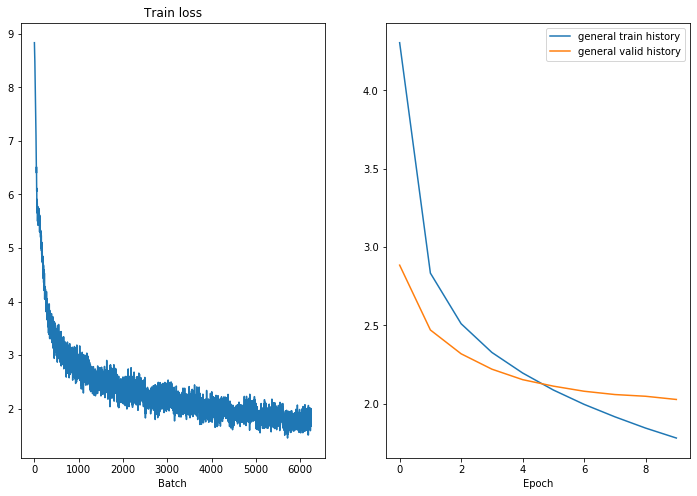

| Test Loss: 1.968 | Test PPL:   7.154 |


In [140]:
train_model(transformer_model, train_iterator, valid_iterator, test_iterator, trg_field, n_epochs=10)

In [142]:
examples = calc_metrics(transformer_model, predict_model, get_original_text, get_generated_text, trg_field, test_iterator, n_examples=10)

118it [00:00, 135.01it/s]


elapsed: 0.8756623268127441
time for batch with size 32 = 0.0037104335881895938 s
bleu: 25.517869230627678

best 10 translations:

	original: the property offers free parking .
	generated: the property offers free parking .
	score = 100.0

	original: room service is available .
	generated: room service is available .
	score = 100.0

	original: bed linen is featured .
	generated: bed linen is featured .
	score = 100.0

	original: towels are featured .
	generated: towels are featured .
	score = 100.0

	original: guests can enjoy the on - site restaurant .
	generated: guests can enjoy the on - site restaurant .
	score = 100.0

	original: you will find a 24 - hour front desk at the property .
	generated: you will find a 24 - hour front desk at the property .
	score = 100.0

	original: free wifi access is available .
	generated: free wifi access is available .
	score = 100.0

	original: guests can enjoy the on - site bar .
	generated: guests can enjoy the on - site bar .
	score = 100.0

	or

Неожиданно, хотя результат оказался и неплохим (побили порог 25), но заметно хуже, чем в случае в CNN. Однако видим, что на протяжении всех 10 эпох лосс на валидации падал, и, возможно, если дать еще пообучаться, то результат бы был лучше.

Итого, подводя итоги:

| Эксперимент      | BLEU | Длительность одной эпохи на обучении | Скорость на инференсе (батч 32) | Склонность к переобучению |
| ----------------- | ----------- | ----------- | ----------- | ----------- | 
| rnn + attention      | 28.21       | 1 m 55 s | 0.0177 s | после 3 эпохи |
| pretrained emb   | 18.13        | 57 s | 0.0099 s | после 7 эпохи |
| cnn   | 37.35        | 55 s | 0.0099 s | на 10 эпохах не начало |
| transfprmer   | 25.52        | 19 s | 0.0037 s | на 10 эпохах не начало |